# FEM Application
After developing the theory for a Finite Element Method in *Theory_FEM.ipynb*, we present a small implementation of what such a simulation might look like.



In [1]:
# Import the necessary libraries
from fem import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.colors as colors


# Control variables
# These are the variables that control our simulation.
bounds  = [(0,1),(0,1)]         # Domain bounds
h       = 1e-2                  # Mesh Fineness parameter
FF      = lambda r,z: abs(1.3*r)    # Discretisation function
dt      = 1e-1                  # Simulation time step  

# Define a Source function
# f0      = lambda r,z,t: np.exp(-((z-v*t)**2 + r**2)/a -(t-t0)**2/b)
# f       = lambda r,z,t: f(r,z,t)* ( (2*v/a*(z-t*v) -2/b *(t-t0))**2 - (2/b+2*v*2/a))
f0      = lambda r,z,t: np.exp(-((z-v*t)**2 + r**2)/a)
f       = lambda r,z,t: a*f0(r,z,t)* ( (2*v/a*(z-t*v))**2 - (2*v*2/a))/10 * (1/(1+np.exp(-20*(t-0.2))))
v       = 1e-0                  # Source wave speed
a       = 1e-2                  # Source std
b       = 2e-1                  # Source offset
# t0      = 

# Now we will get the mesh and points
points,mesh = get_mesh(h,FF,bounds)
boundary    = get_boundary(points)

# Buld T, S matrices
T,S = get_TS(points,mesh)

# Construct the scheme matrix and apply boundary conditions
Ap= get_scheme_matrix(dt,T,S)
A = set_bc_lhs(boundary,Ap,points,mesh)

# Define the initial condition vectors
# Goal is to solve for U_next, using U_curr and U_prev
ff = lambda r,z: np.exp(-((z-0.5)**2 + (r)**2)/s)
# U_curr = np.array([ff(*p) for p in points])
# U_prev = np.array([0.1*ff(*p) for p in points])
U_curr = np.zeros(len(points))
U_prev = np.zeros(len(points))
F      = np.array([f(*point,0) for point in points])

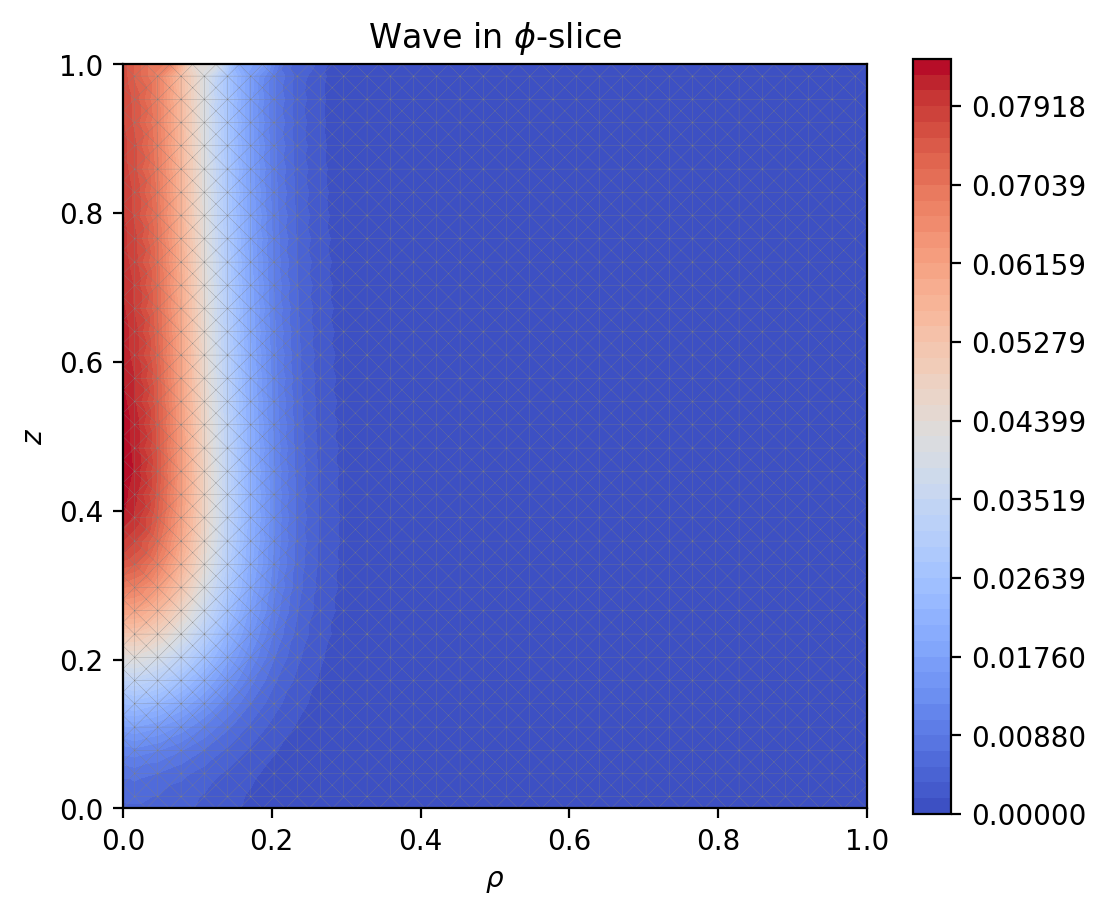

In [5]:
# Let's take one step in time and plot
# U = step(dt,A,S,T,U_curr,U_prev,F)

U_curr = run(40,dt,A,S,T,U_curr,U_prev,f,points);
# plot_U(points,mesh,U)

# t = 0.5
# # Get the number of iterations
# N = int(t//dt)
# Ff = []
# # Display a progress bar for fun
# for i in range(N):
#     Ff = get_F(f,i*dt,points)
#     U_curr, U_prev = step(dt,A,S,T,U_curr,U_prev,Ff)

plot_U(points,mesh,U_curr)

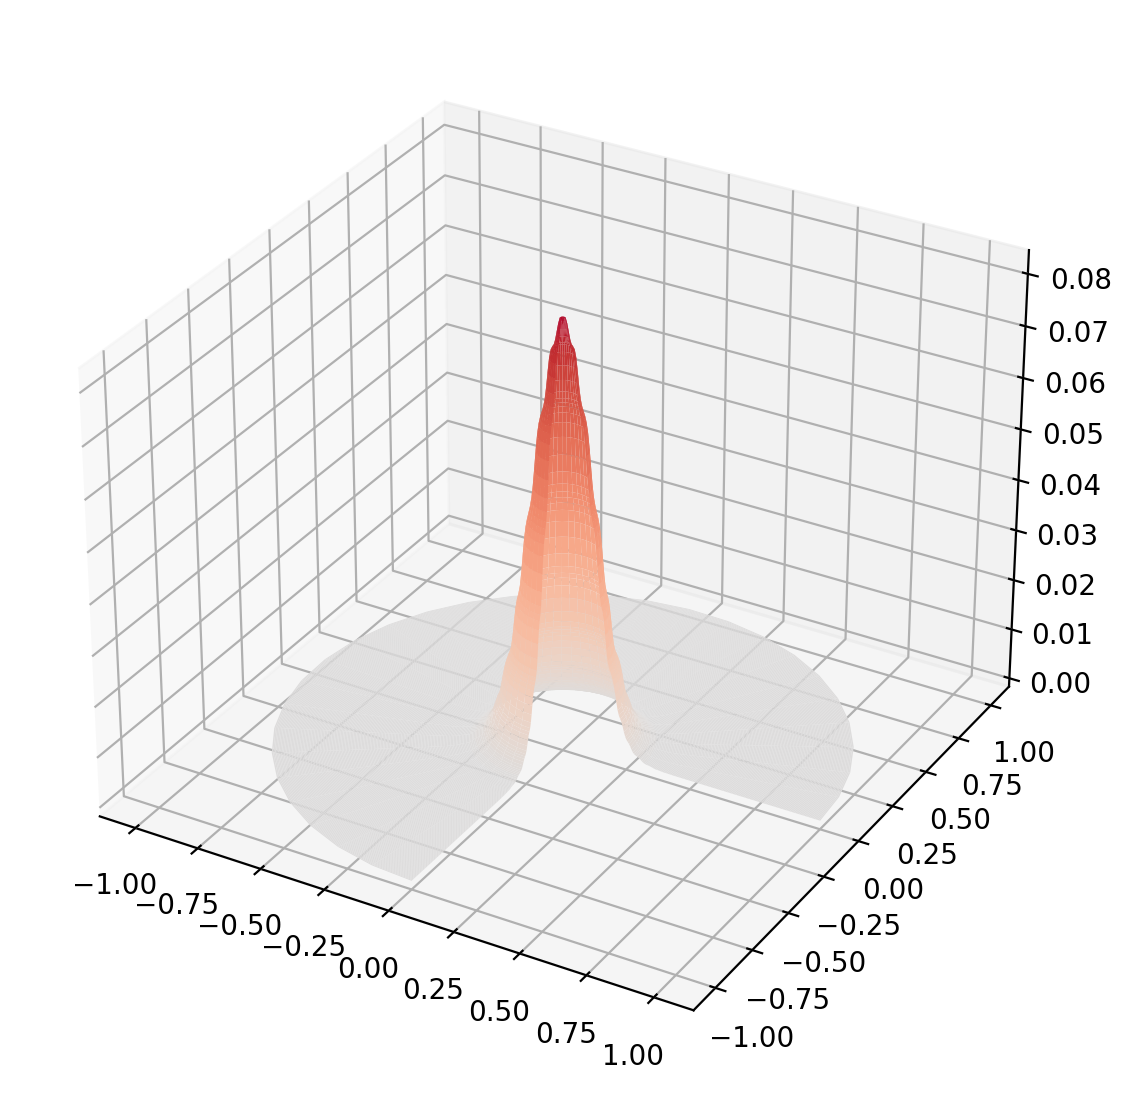

In [6]:
# Let's Plot a 3D slice from a particular z value
# We will first average the z-values along that line
# Collect the z values

z = 0.4
Npts = 200
RR  = np.linspace(bounds[0][0],bounds[0][1],70)
U = np.array([np.mean(U_curr[mesh.simplices[mesh.find_simplex([r,z]) ]]) for r in RR])

interp = interpolate.make_interp_spline(RR,U)
U = interp(RR)

f = lambda x,y: interp((x**2+y**2)**0.5)
R = np.linspace(bounds[0][0],bounds[0][1],Npts)
theta = np.linspace(0,6/4*np.pi,30)

R,theta = np.meshgrid(R,theta)

X = R*np.cos(theta)
Y = R*np.sin(theta)
Z = f(X,Y)

fig = plt.figure(dpi=200,figsize=(7,7))
ax = fig.add_subplot(111,projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='coolwarm', edgecolor='none',norm=colors.CenteredNorm());


# Create the figure

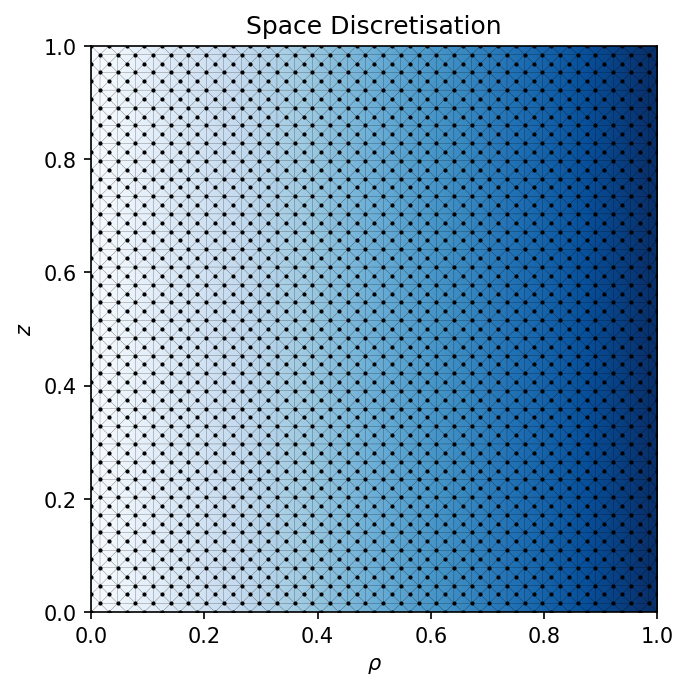

In [4]:
# Now let's print some stuff before we start solving.A
# Firstly the mesh.
plot_mesh(points,mesh,FF);

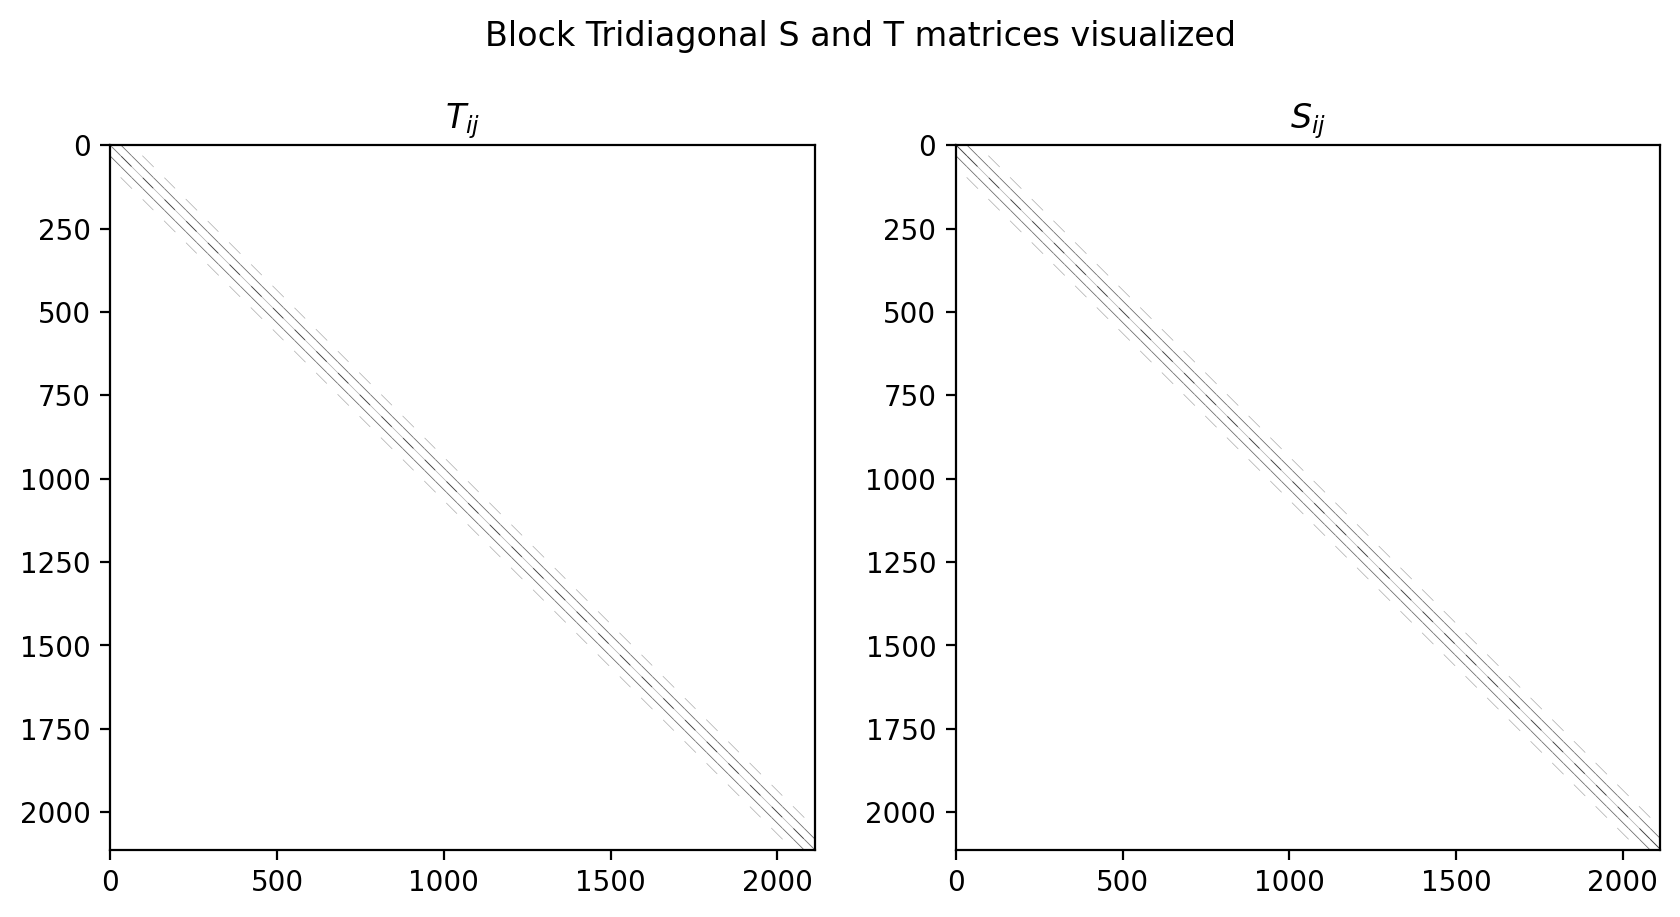

In [5]:
# Now let's plto the T,S Matrices
plot_TS(T,S);

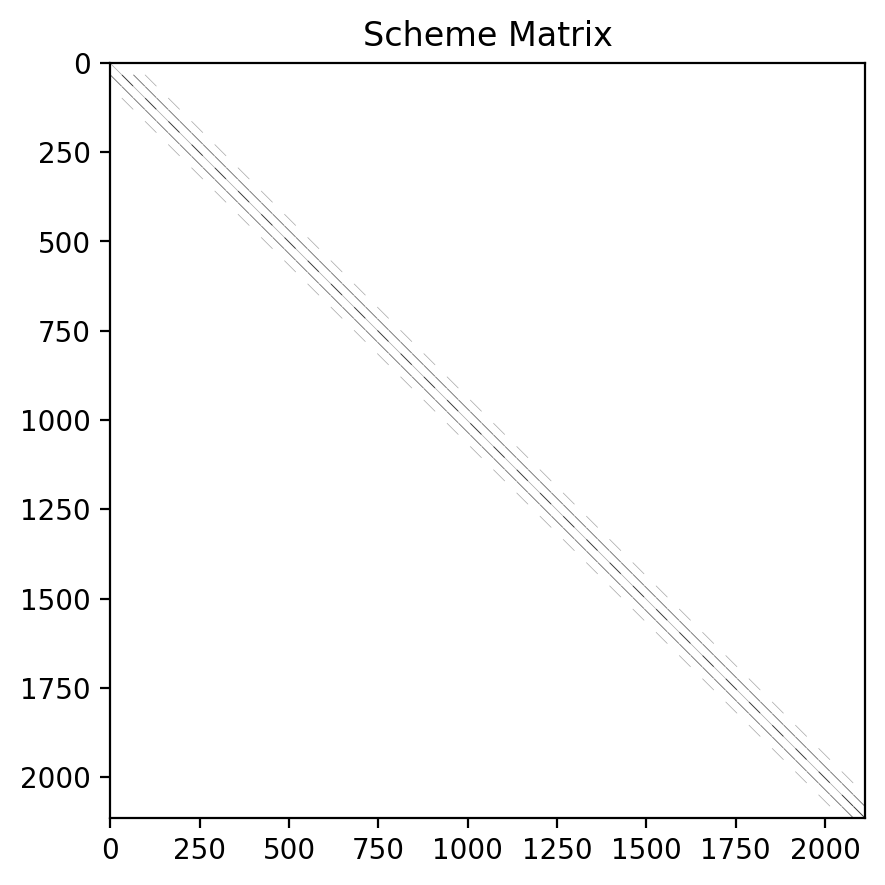

In [6]:
# Plotting the A matrix
plot_A(Ap);

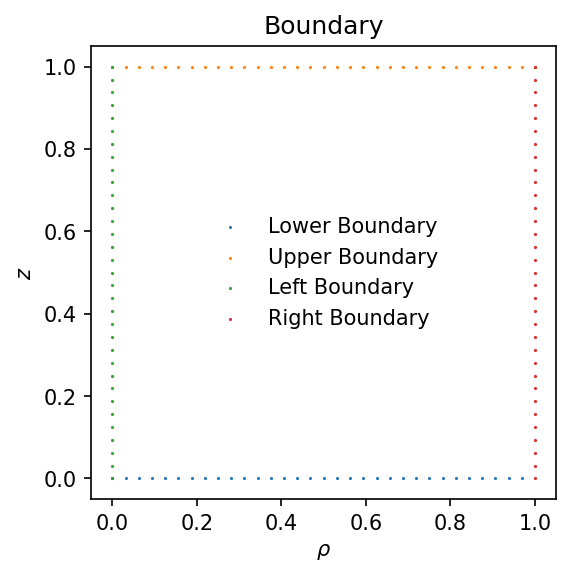

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:title={'center':'Boundary'}, xlabel='$\\rho$', ylabel='$z$'>)

In [7]:
plot_boundary(boundary,points)